In [1]:
!pip install tensorflow==2.13.0
!pip install tflite-support==0.4.3

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Found 6800 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.
Epoch 1/20
106/106 [==============================] - 156s 1s/step - loss: 0.8809 - accuracy: 0.7754 - val_loss: 0.4360 - val_accuracy: 0.9280
Epoch 2/20
106/106 [==============================] - 153s 1s/step - loss: 0.4482 - accuracy: 0.9120 - val_loss: 0.3267 - val_accuracy: 0.9618
Epoch 3/20
106/106 [==============================] - 154s 1s/step - loss: 0.3679 - accuracy: 0.9353 - val_loss: 0.2847 - val_accuracy: 0.9679
Epoch 4/20
106/106 [==============================] - 153s 1s/step - loss: 0.3397 - accuracy: 0.9415 - val_loss: 0.2749 - val_accuracy: 0.9644
Epoch 5/20
106/106 [==============================] - 153s 1s/step - loss: 0.2914 - accuracy: 0.9546 - val_loss: 0.2390 - val_accuracy: 0.9740
Epoch 6/20
106/106 [==============================] - 152s 1s/step - loss: 0.2787 - accuracy: 0.9549 - val_loss: 0.2197 - val_accuracy: 0.9748
Epoch 7/20
106/106 [==============================] - 152s

INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmpq_9_la2f\assets


INFO:tensorflow:Assets written to: C:\Users\henry\AppData\Local\Temp\tmpq_9_la2f\assets


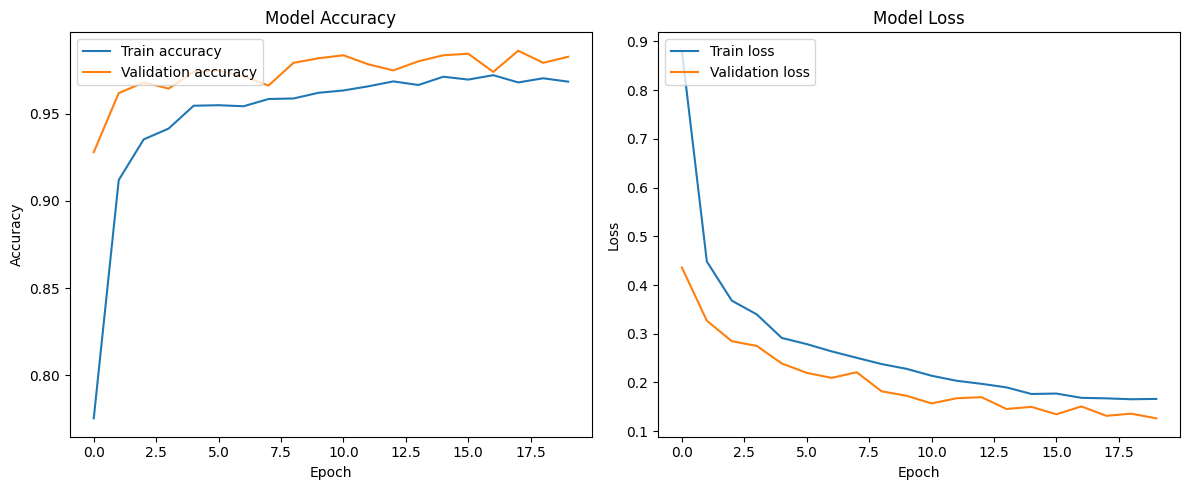

Number of training samples: 6800
Number of validation samples: 1200


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Define paths and set hyperparameters
train_data_dir = '../data/train_disease'

# Function to exclude the '.ipynb_checkpoints' directory
def filter_folders(directory):
    return [folder for folder in os.listdir(directory) if folder != '.ipynb_checkpoints']

img_height, img_width = 224, 224
batch_size = 64
epochs = 20
learning_rate = 0.0005  # Reduced learning rate for smoother convergence

seed_value = 42

# Set seed for reproducibility
tf.random.set_seed(seed_value)

# Data Preprocessing with 15% validation split and enhanced augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  # Adjust brightness for more robust training
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # 15% for validation
)

# No augmentation for validation data, just rescaling
validation_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.15)

# Load training data (85% training)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',  # 85% training split
    classes=filter_folders(train_data_dir)
)

# Load validation data (15% validation)
validation_generator = validation_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # 15% validation split
    classes=filter_folders(train_data_dir)
)

# Load the pre-trained MobileNetV2 model, excluding its top layers
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Set base layers to train partially (fine-tuning), using gradual unfreezing
base_model.trainable = False

# Build the model (Custom Head)
model = models.Sequential([
    base_model,  # Pre-trained MobileNetV2 as feature extractor
    layers.GlobalAveragePooling2D(),  # Pooling layer
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 regularization to prevent overfitting
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
)

# Save the trained model
model.save('../models/MobileNetV2_Disease_Detection_Model.keras')

# Convert to TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('../models/MobileNetV2_Disease_Detection_Model.tflite', 'wb') as f:
    f.write(tflite_model)

# Plot the training and validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# 14. Optionally, print the number of samples
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")

In [4]:
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support.metadata_writers import image_classifier
import os

# Load your TensorFlow Lite model file
model_file = "../models/MobileNetV2_Disease_Detection_Model.tflite"

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "MobileV2 Disease Detection Model"
model_meta.description = ("This model identifies plant diseases based on input images. "
                          "It classifies the plant into zero or more known categories of plant diseases.")
model_meta.version = "v1"
model_meta.license = ("Apache License, Version 2.0 "
                      "http://www.apache.org/licenses/LICENSE-2.0.")

# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()
input_meta.name = "input_image"
input_meta.description = (
    "Input image for plant disease identification. The image should be resized to 224 x 224 pixels "
    "with three RGB channels. Each value in the tensor is a single byte between 0 and 255.")
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)

# Input normalization settings
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [0.0]  # Normalization mean
input_normalization.options.std = [255.0]   
input_meta.processUnits = [input_normalization]

# Input statistics
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "plant_probability"
output_meta.description = "Probabilities corresponding to different plant disease classifications."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.FeatureProperties)

# Output statistics
output_stats = _metadata_fb.StatsT()
output_stats.max = [1.0]
output_stats.min = [0.0]
output_meta.stats = output_stats

# Associated label file
label_file = _metadata_fb.AssociatedFileT()
label_file.name = os.path.basename("disease_labels.txt")  # Ensure the filename matches your labels file
label_file.description = "Labels for plant diseases that the model can recognize."
label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
output_meta.associatedFiles = [label_file]

# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

# Creates Flatbuffer metadata
b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

# Pack metadata and associated files into the model
populator = _metadata.MetadataPopulator.with_model_file(model_file)
populator.load_metadata_buffer(metadata_buf)
populator.load_associated_files(["disease_labels.txt"])  # Ensure this file exists in the specified location
populator.populate()

# Verify the metadata generated by the populator
print("Metadata populated successfully.")

Metadata populated successfully.


In [5]:
import numpy as np
import os
import tensorflow as tf
from PIL import Image

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="../models/MobileNetV2_Disease_Detection_Model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to match model input
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array.astype(np.float32)

# Function to get class names based on disease_labels.txt
def get_class_names():
    return [
        'Bacterial Spot',
        'Black Rot',
        'Blight',
        'Healthy',
        'Leaf Scorch',
        'Mold',
        'Powdery Mildew',
        'Rust'
    ]

# Main function to classify images in a directory
def classify_images_in_directory(directory):
    # Get the class names based on the predefined list
    class_names = get_class_names()  # Reflects the disease classes

    # Iterate through files in the directory
    for img_file in os.listdir(directory):
        img_path = os.path.join(directory, img_file)
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            print(f"Classifying image: {img_file}")  # Debugging line
            img_array = preprocess_image(img_path)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], img_array)

            # Run the model
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])
            confidence_scores = output_data[0]

            # Get predicted class index
            predicted_class_index = np.argmax(confidence_scores)
            confidence = confidence_scores[predicted_class_index]

            # Print the class name and confidence
            print(f"Image: {img_file}, Predicted Class: {class_names[predicted_class_index]}, Confidence: {confidence:.4f}")

# Change this directory to the path where your images are stored
image_directory = '../data/test_disease' 
classify_images_in_directory(image_directory)

Classifying image: blight_testing_008.JPG
Image: blight_testing_008.JPG, Predicted Class: Blight, Confidence: 0.6977
Classifying image: blight_testing_009.JPG
Image: blight_testing_009.JPG, Predicted Class: Leaf Scorch, Confidence: 0.7068
Classifying image: blight_testing_010.JPG
Image: blight_testing_010.JPG, Predicted Class: Blight, Confidence: 0.8713
Classifying image: blight_testing_011.JPG
Image: blight_testing_011.JPG, Predicted Class: Bacterial Spot, Confidence: 0.8546
Classifying image: blight_testing_012.JPG
Image: blight_testing_012.JPG, Predicted Class: Blight, Confidence: 0.9382
Classifying image: blight_testing_013.JPG
Image: blight_testing_013.JPG, Predicted Class: Blight, Confidence: 0.9695
Classifying image: blight_testing_014.JPG
Image: blight_testing_014.JPG, Predicted Class: Blight, Confidence: 0.9041
Classifying image: blight_testing_015.JPG
Image: blight_testing_015.JPG, Predicted Class: Blight, Confidence: 0.6644
Classifying image: blight_testing_016.JPG
Image: bl